In [1]:
%cd ../..

c:\Users\aldion\Desktop\Development\virtusize-algo


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

from src.steps.load_data import load_experiment_data
from src.steps.predict import predict_serving_data
from src.steps.train import train
from src.utils.error_analyzer import ErrorAnalyzer
from src.utils.error_calculator import calculate_split_errors, get_split_error_data
from src.utils.feature_engineer import BMIProxyEngineer, FeatureScaler
from src.utils.ground_truths import get_ground_truth_values
from src.utils.metrics import MetricsManager
from src.utils.models import FitParams, ModelNames, VirtusizeModels
from src.utils.neural_net import build_model
from src.utils.predictions import get_train_val_test_predictions






In [3]:
RANDOM_SEED= 100
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [4]:
scaler = FeatureScaler(StandardScaler(), cols_to_scale=["age", "weight", "height", "bmi_proxy"])
bmi_engineer = BMIProxyEngineer()
feature_engineers = [bmi_engineer, scaler] # Ensure bmi_engineer is added first so that the bmi_proxy columns is added at the time scaling is being done


In [5]:
experiment_data = load_experiment_data(feature_engineers=feature_engineers)
train_val_test = experiment_data.train_val_test

In [6]:
train_val_test.train.bust.features.head()

,gender,age,height,weight,bmi_proxy
664,1,-1.005660,1.108536,-0.236478,0.492185
1013,0,0.180270,-0.516276,-1.256858,1.588829
153,0,0.319791,0.195970,-0.252298,0.199040
392,0,1.156918,-0.149024,-0.109919,-0.101876
3598,1,1.575482,-0.126767,0.538694,-0.806016


In [7]:
train_val_test.train.bust.targets.head()

664     830.0
1013    765.0
153     823.0
392     986.0
3598    976.0
Name: bust_circumference, dtype: float64

In [8]:
universal_fit_params = {"batch_size": 64, "epochs":500}
fit_params = FitParams()
fit_params.update_with_validation_data(train_val_test)
fit_params.update_all(universal_fit_params)

In [9]:
bust_callbacks = {"callbacks": [EarlyStopping(monitor="val_loss", min_delta=0, patience=100, restore_best_weights=True)]}
hip_callbacks = {"callbacks": [EarlyStopping(monitor="val_loss", min_delta=0, patience=100, restore_best_weights=True)]}
waist_callbacks = {"callbacks": [EarlyStopping(monitor="val_loss", min_delta=0, patience=100, restore_best_weights=True)]}

In [10]:
fit_params.bust.update(bust_callbacks)
fit_params.hip.update(hip_callbacks)
fit_params.waist.update(waist_callbacks)

In [11]:
num_features = 5
bust_model = build_model(num_features)
hip_model = build_model(num_features)
waist_model = build_model(num_features)

models = VirtusizeModels(bust_model, hip_model, waist_model, names=ModelNames(bust="nn_bust", hip="nn_hip", waist="nn_waist"))

In [12]:
train_history = train(models, train_val_test.train, fit_params)

Training bust circumference  prediction model...
Epoch 1/500
57/57 [==============================] - 2s 7ms/step - loss: 726971.5000 - val_loss: 343064.5000
Epoch 2/500
57/57 [==============================] - 0s 4ms/step - loss: 95743.8984 - val_loss: 37803.6758
Epoch 3/500
57/57 [==============================] - 0s 4ms/step - loss: 35575.0938 - val_loss: 20964.8848
Epoch 4/500
57/57 [==============================] - 0s 4ms/step - loss: 23856.7539 - val_loss: 12779.3223
Epoch 5/500
57/57 [==============================] - 0s 4ms/step - loss: 16644.2715 - val_loss: 7271.1113
Epoch 6/500
57/57 [==============================] - 0s 4ms/step - loss: 12257.6465 - val_loss: 4142.0918
Epoch 7/500
57/57 [==============================] - 0s 4ms/step - loss: 9224.2197 - val_loss: 2597.8694
Epoch 8/500
57/57 [==============================] - 0s 4ms/step - loss: 8312.5625 - val_loss: 1955.6975
Epoch 9/500
57/57 [==============================] - 0s 4ms/step - loss: 7775.0103 - val_loss: 1671

### Universal Metrics Analysis

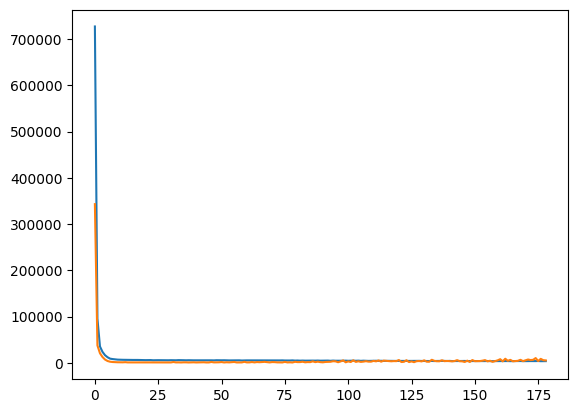

In [13]:
plt.plot(train_history.bust.history["loss"])
plt.plot(train_history.bust.history["val_loss"])

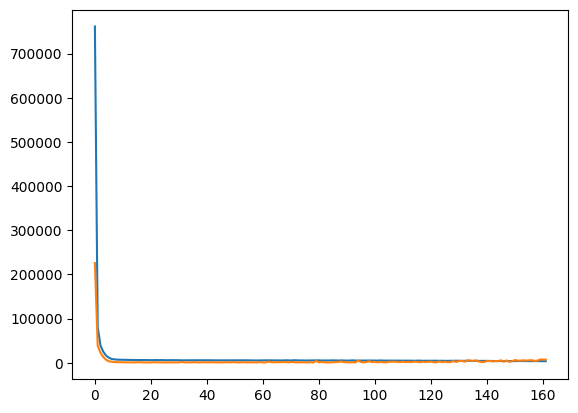

In [14]:
plt.plot(train_history.hip.history["loss"])
plt.plot(train_history.hip.history["val_loss"])

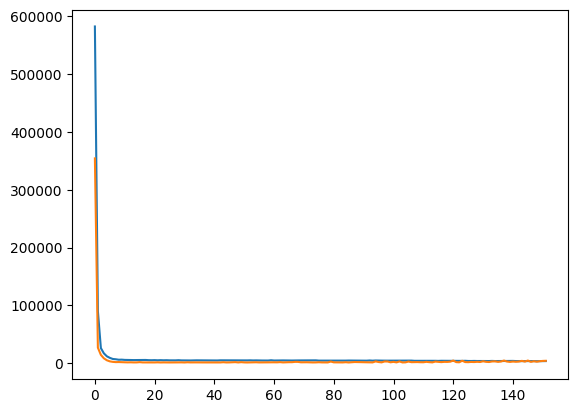

In [15]:
plt.plot(train_history.waist.history["loss"])
plt.plot(train_history.waist.history["val_loss"])

- A comparison of the model's history on the train and validation sets suggests that all models are highly likely to generalize the performances obtained on the training set, to unseen test data, with similar feature distribution patterns.

In [16]:
predictions = get_train_val_test_predictions(models, train_val_test)

25/25 [==============================] - 0s 2ms/step


In [17]:
ground_truths = get_ground_truth_values(train_val_test)

In [18]:
metrics_manager = MetricsManager()
metrics = metrics_manager.update_metrics(ground_truths, predictions)

In [19]:
metrics

,train_mae,val_mae,test_mae,train_mse,val_mse,test_mse,train_r2,val_r2,test_r2
nn_bust,23.267376,23.519628,24.428308,910.290706,955.645413,957.220572,0.876639,0.863143,0.867188
nn_hip,17.599575,18.342379,17.926656,541.154016,562.821416,528.544226,0.862197,0.848136,0.858084
nn_waist,24.833774,25.430935,23.788914,1058.451937,1143.662002,953.731471,0.897526,0.889034,0.903683


In [20]:
metrics_manager.show_validation_metrics()

,val_mae,val_mse,val_r2
nn_bust,23.519628,955.645413,0.863143
nn_hip,18.342379,562.821416,0.848136
nn_waist,25.430935,1143.662002,0.889034


- The table above compares the performance of the classifiers using the metrics; mean absolute error (mae), mean squared error (mse) and r squared score. Comparing the performance of the classifiers on the train and validation sets suggests that this performance can be generalized to unseen data.

### Error Analysis

In [21]:
split_errors = calculate_split_errors(ground_truths.val, predictions.val)

In [22]:
error_data = get_split_error_data(ground_truths.val, predictions.val, experiment_data.original_preprocessed)

In [23]:
error_data

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
9,1,17.0,1654.0,61.3,845.0,738.0,910.0,7.589600,9.259033,2.450745,7.589600,9.259033,2.450745
11,0,58.0,1539.0,54.6,891.0,800.0,875.0,3.907898,21.190063,-10.869690,3.907898,21.190063,10.869690
22,0,33.0,1605.0,58.0,872.0,756.0,945.0,-1.548828,-10.124329,-7.308350,1.548828,10.124329,7.308350
24,1,26.0,1786.0,72.8,971.0,813.0,940.0,-61.986938,23.110840,-12.647461,61.986938,23.110840,12.647461
32,1,24.0,1715.0,70.6,906.0,789.0,977.0,2.072998,-18.424133,15.855652,2.072998,18.424133,15.855652
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5128,0,22.0,1535.0,42.5,744.0,626.0,794.0,8.209045,39.774780,-3.594849,8.209045,39.774780,3.594849
5130,0,44.0,1628.0,59.3,915.0,770.0,926.0,-26.458313,8.010498,1.131165,26.458313,8.010498,1.131165
5132,1,32.0,1756.0,65.4,896.0,820.0,930.0,-20.110779,-9.005981,-60.775574,20.110779,9.005981,60.775574
5134,1,27.0,1760.0,75.0,930.0,845.0,983.0,-0.491943,-7.923828,-16.958557,0.491943,7.923828,16.958557


In [24]:
error_analyzer = ErrorAnalyzer(error_data, column_num_categories_map={"age": 10, "weight": 10, "height": 10})

In [25]:
error_analyzer.get_category_means("gender")

,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
gender,,,,,,,,,,,,
0,33.796392,1581.417526,56.604897,871.868557,755.912371,928.855670,-2.774754,-3.159486,-3.934994,24.663234,20.467498,27.643670
1,31.540682,1719.829396,71.408399,923.440945,822.645669,955.446194,-2.394963,-1.393141,0.683735,22.355012,16.178216,23.177546


In [26]:
error_analyzer.get_category_counts("gender")

gender
0    388
1    381
dtype: int64

- As we have seen with all models so far, the mean absolute errors for each target is higher for females, with the biggest disparity coming in the prediction of waist circumference.

In [27]:
error_analyzer.get_category_st_devs("gender")

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
gender,,,,,,,,,,,,,
0,0.000000,15.720736,57.415612,8.383898,77.880663,91.530416,53.723949,32.764845,26.271882,36.913260,21.747625,16.771274,24.777014
1,0.000000,14.449534,60.511423,12.170386,81.087263,100.117794,64.685635,28.670774,20.517894,30.074521,18.110841,12.696068,19.176696


- The standard deviations confirms that the models perform better when making predictions for males.

In [28]:
error_analyzer.get_category_counts("gender")

gender
0    388
1    381
dtype: int64

In [29]:
male_error_data = error_data[error_data["gender"] == 1]
female_error_data = error_data[error_data["gender"] == 0]

#### The charts below show the distributions of the absolute errors for both genders

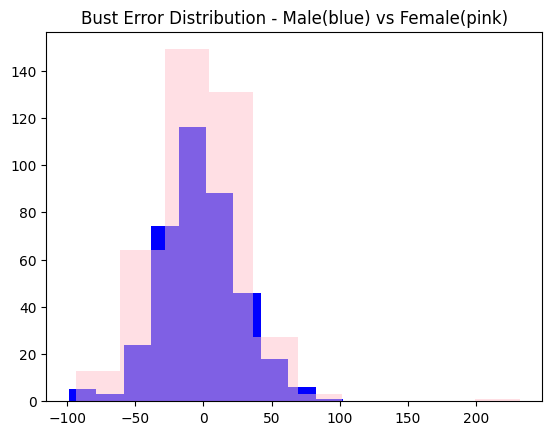

In [30]:
plt.hist(male_error_data["bust_errors"], bins=10, color="blue")
plt.hist(female_error_data["bust_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Bust Error Distribution - Male(blue) vs Female(pink)")
plt.show()


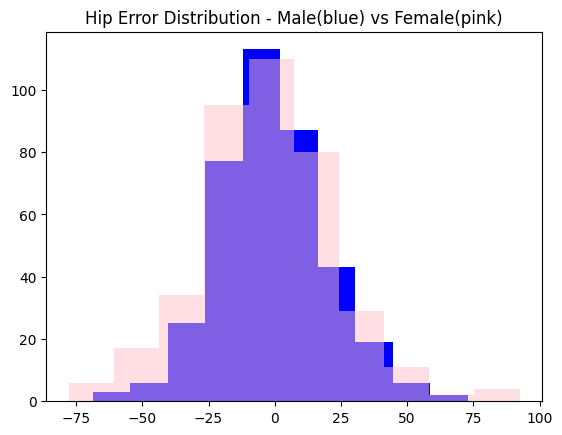

In [31]:
plt.hist(male_error_data["hip_errors"], bins=10, color="blue")
plt.hist(female_error_data["hip_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Hip Error Distribution - Male(blue) vs Female(pink)")
plt.show()

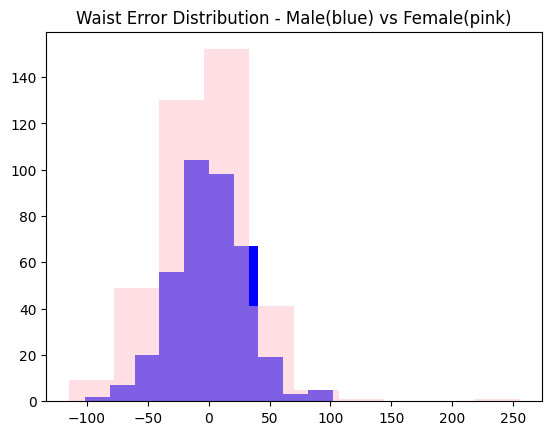

In [32]:
plt.hist(male_error_data["waist_errors"], bins=10, color="blue")
plt.hist(female_error_data["waist_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Waist Error Distribution - Male(blue) vs Female(pink)")
plt.show()

- The graphs indicate a relatively similar distribution of errors, but do confirm higher error rates when predicting female data.

### Further Error Analysis

In [33]:
error_analyzer.get_category_counts("age")

age
0    259
1     80
2     86
3     82
4     57
5     40
6     47
7     56
8     36
9     26
dtype: int64

In [34]:
error_analyzer.get_category_bin("age", 0)
# Most of the examples have individuals aged 15 to 20

(14.946, 20.4)

In [35]:
error_analyzer.get_category_means("age")

,gender,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
age,,,,,,,,,,,,
0,0.513514,1662.366795,61.010425,857.243243,735.849421,934.563707,-2.073758,-0.567549,-0.257893,22.978475,16.571159,22.289311
1,0.537500,1676.100000,65.787500,891.850000,776.862500,953.250000,-1.846407,0.506186,0.025438,20.861989,18.227493,23.537816
2,0.523256,1677.267442,67.083721,909.267442,795.174419,960.802326,-7.855396,-5.092993,-2.393558,24.153254,20.414100,27.816572
3,0.524390,1670.195122,67.046341,917.768293,812.073171,952.475610,-8.642910,-0.308848,-8.198590,21.797479,14.681315,26.193082
4,0.614035,1664.631579,66.975439,916.105263,812.807018,949.315789,-2.517446,-6.788534,0.125573,24.962035,15.905027,23.388257
5,0.400000,1617.050000,61.337500,896.100000,791.125000,923.800000,0.820357,-2.725986,2.431792,22.487373,23.262781,31.273970
6,0.425532,1616.170213,66.459574,940.744681,856.914894,950.234043,2.149571,-4.752758,-5.651693,22.888008,23.713532,23.599522
7,0.375000,1598.482143,64.594643,949.375000,854.464286,935.803571,-5.816802,-0.111604,-0.820560,24.969736,20.397445,32.452775
8,0.250000,1566.388889,62.022222,933.944444,854.416667,927.611111,9.893070,-1.949792,0.076440,31.040734,18.736559,34.949765


- As was the case with the baseline models, the neural networks' performances generally degrade for older people who are comparatively underrepresented in the dataset.

In [36]:
error_analyzer.get_category_means("height")

,gender,age,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
height,,,,,,,,,,,,
0,0.000000,46.928571,52.392857,884.714286,781.000000,894.428571,5.581892,8.422638,10.499067,18.417594,18.497110,26.491342
1,0.000000,45.564103,54.374359,897.871795,800.897436,905.179487,-5.808332,3.297720,-12.727106,24.218254,26.705473,27.836261
2,0.010638,37.489362,55.229787,876.106383,770.148936,921.712766,-2.267981,-6.183537,-8.928778,24.098876,20.539030,29.053150
3,0.084615,33.669231,56.565385,870.069231,753.300000,928.938462,-5.107784,-7.721646,-4.293545,25.173754,20.596208,25.953043
4,0.330769,31.230769,59.563077,867.438462,756.230769,926.515385,1.312746,0.371075,-1.494223,24.399047,18.146498,26.685735
5,0.740385,31.605769,67.067308,911.250000,800.269231,946.451923,-4.958025,0.885122,3.850065,21.971164,16.630385,22.261801
6,0.941667,30.550000,70.316667,917.108333,810.958333,955.008333,-2.857984,-2.775828,1.509937,22.508904,15.468877,22.188933
7,0.975610,27.731707,75.653659,938.268293,834.170732,977.743902,-2.417637,-0.161110,1.582404,25.033717,16.336884,25.852857
8,1.000000,26.545455,76.129545,926.136364,823.159091,982.363636,0.625775,-5.587484,-1.633298,18.613976,15.103947,23.590299


In [37]:
error_analyzer.get_category_counts("height")

height
0     14
1     39
2     94
3    130
4    130
5    104
6    120
7     82
8     44
9     12
dtype: int64

- The bust circumference prediction model seems especially prone to larger errors when prediction people with heights further away from being average. This could lead us to hypothesize that getting more data could for underrepresented groups could possible improve performance.

In [38]:
error_analyzer.get_category_means("weight")

,gender,age,height,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
weight,,,,,,,,,,,,
0,0.066667,28.693333,1566.146667,780.666667,661.080000,860.880000,0.987026,-5.210585,-6.362380,21.508613,18.780745,21.894487
1,0.191489,31.638298,1595.622340,843.643617,721.611702,903.765957,-5.624749,-2.398432,-4.709394,22.775546,18.140607,22.562604
2,0.399038,33.557692,1630.548077,889.658654,780.144231,937.884615,-0.567535,-3.366827,-4.283772,21.840816,18.241271,26.307535
3,0.822695,33.631206,1703.921986,929.808511,819.659574,955.879433,-7.729110,0.836249,1.543342,25.578219,16.239077,26.137371
4,0.872340,35.819149,1717.457447,967.776596,875.542553,993.776596,4.657878,-1.786526,8.465896,24.054759,20.059958,26.099149
5,0.921053,33.500000,1749.657895,1018.421053,938.000000,1036.500000,-0.849622,-4.028018,-2.144303,25.958843,18.678178,30.754680
6,0.933333,25.733333,1743.933333,1065.133333,1005.733333,1063.533333,-3.983398,13.827393,-2.830001,36.463916,25.867106,42.581555
7,1.000000,31.428571,1784.714286,1092.571429,1040.714286,1114.000000,-4.811192,-23.034232,2.971627,19.678798,23.034232,25.350586
8,1.000000,22.000000,1806.500000,1128.000000,1061.000000,1159.000000,-12.128174,-21.114075,36.897461,12.128174,21.114075,36.897461


In [39]:
error_analyzer.get_category_counts("weight")

weight
0     75
1    188
2    208
3    141
4     94
5     38
6     15
7      7
8      2
9      1
dtype: int64

- As was the case with height, we see where the wait circumference prediction model, in particular, does comparatively worse as the weight of the individual increases. Interestingly however, we do not see this for outlier weights on the low side. Of course, this is perhaps mostly likely due to the comparative under representation of heavier people in the dataset. Since these heavier individuals in categories (6 - 10) as seen in the datframe are almost always men, the earlier drawn inference that the model performed better on average for males than females indicates that the models likely do very well for men of average height and weight, in comparison to women of average height and weight

### Unseen Targets Test Set Predictions

In [41]:
predict_serving_data(models, feature_engineers=feature_engineers, predictions_file_name="nn1_predicted.csv")

No data for train split so split was not scaled.
No data for val split so split was not scaled.
 1/41 [..............................] - ETA: 0s

41/41 [==============================] - 0s 2ms/step


,gender,age,height,weight,bust_circumference,hip_circumference,waist_circumference
0,M,27,"1,729",74.7,935.806335,975.726685,837.195496
1,M,25,"1,645",58.6,843.382202,894.315552,730.380676
2,M,28,"1,786",75.2,925.844727,973.575256,822.361755
3,M,19,"1,686",60.8,845.106934,909.384888,724.803467
4,M,24,"1,764",68.3,883.477417,942.597534,767.052856
...,...,...,...,...,...,...,...
1279,F,33,"1,618",54.0,829.619507,906.552734,703.166077
1280,F,25,"1,549",56.4,866.082275,939.533020,747.274414
1281,F,28,"1,623",58.5,864.079102,941.803345,738.116760
1282,F,34,"1,566",55.4,859.476685,920.414429,740.843811
